In [48]:
import warnings

import numpy as np
import scipy.stats as stats
import scipy.special as special
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import xarray as xr
import seaborn as sns

from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.formula.api as smf
import statsmodels.api as sm

%matplotlib inline

%config InlineBackend.figure_format = 'retina'
plt.style.use("bmh")
az.rcParams["stats.hdi_prob"] = 0.89

warnings.simplefilter('ignore', category=FutureWarning)

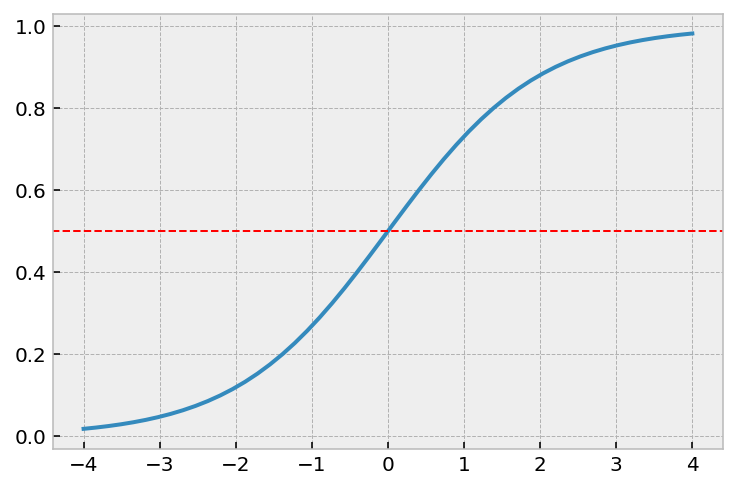

In [49]:
x = np.linspace(-4,4,50)
plt.plot(x, special.expit(x))
plt.axhline(y=0.5, xmin=-4,xmax=4, linestyle='--', color='r', lw=1)

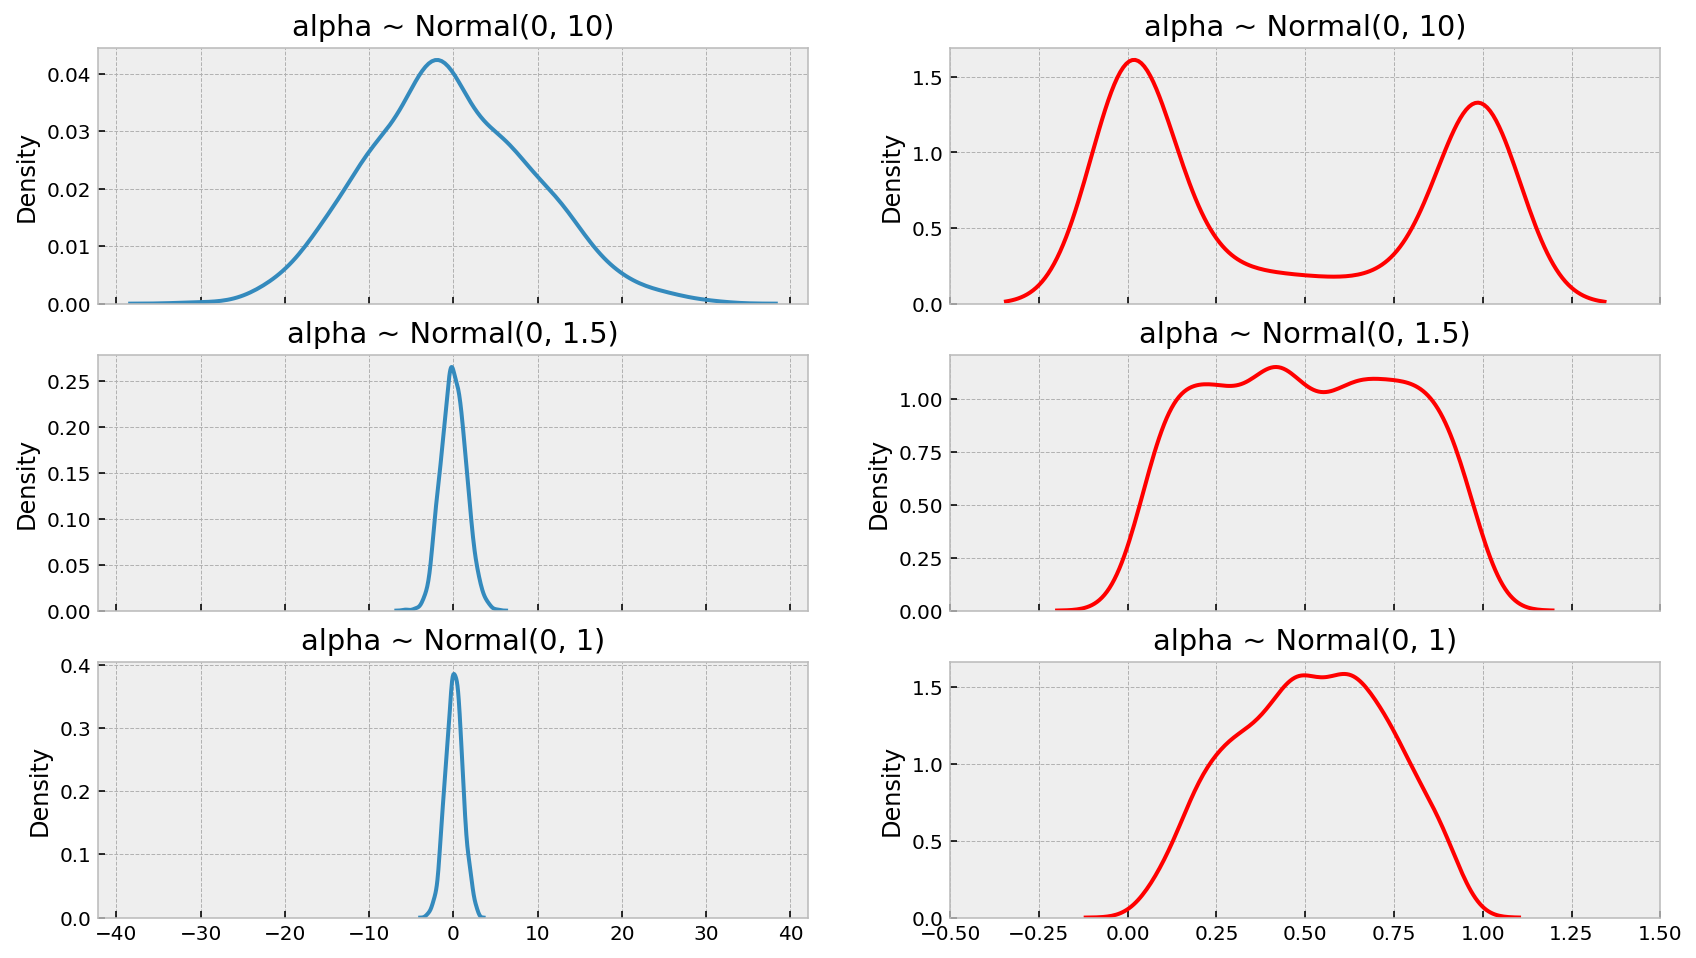

In [50]:
sigmas = [10, 1.5, 1]
_, axes = plt.subplots(3, 2, figsize=(14,8), sharex='col')
for sigma, ax in zip(sigmas, axes):
    x = np.random.normal(0, scale=sigma, size=1000)    
    sns.kdeplot(x, ax=ax[0])
    ax[0].set_title(f"alpha ~ Normal(0, {sigma})")
    sns.kdeplot(special.expit(x), ax=ax[1], color='r')
    ax[1].set_title(f"alpha ~ Normal(0, {sigma})")
    ax[1].set_xlim(-0.5, 1.5)

In [61]:
def gendata(gender_prefrate: np.ndarray, accept_rate: np.ndarray, sample_size=1000):
    """ Generate Department / Gender discrimination data.
    :param:
        gender_prerate: Preference for each gender
        accept_rate: Acceptance rate of each 
    :return: a tuple of Gender, Department and Generated data of acceptance for each gender
    """
    # Number of applicants
    N = sample_size
    # Even gender distribution
    gender = np.random.choice([0, 1], size=N, replace=True)
    # Gender 1 tends to apply to Department 1, respectively
    dept = np.random.binomial(1, p=np.where(gender==0, gender_prefrate[0], gender_prefrate[1]))

    # Simulate accept_rate[dept][gender]
    accept = np.random.binomial(1, p=accept_rate[dept,gender]) 
    return pd.DataFrame({'gender': gender, 'dept': dept, 'accept': accept})

In [62]:
# Department 0 is discrimating against gender 0 
# with acceptance rate of 0.05 for gender 0 instead of 0.2 for gender 1
data = gendata(np.array([0.3, 0.8]), np.array([[0.05, 0.1],[0.2, 0.3]]))
data.head()

,gender,dept,accept
0,1,1,0
1,0,0,0
2,0,1,1
3,0,1,0
4,1,1,0


In [65]:
pd.crosstab(data.gender, data.dept)

dept,0,1
gender,,
0,355,147
1,92,406


In [66]:
pd.crosstab(data.gender, data.accept)

accept,0,1
gender,,
0,441,61
1,372,126


In [68]:
## Total Effect Models
with pm.Model() as m_total:
    a = pm.Normal('a', 0, 1, shape=2)
    p = pm.math.invlogit(a[data.gender.values])
    _ = pm.Bernoulli('AcceptRate', p, observed=data.accept)
    idata_total = pm.sample()
az.summary(idata_total, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-1.95,0.13,-2.17,-1.74,0.0,0.0,3206.27,2370.11,1.00
a[1],-1.07,0.10,-1.24,-0.91,0.0,0.0,3441.44,2701.49,1.01


In [70]:
special.expit(idata_total.posterior.mean(dim=['chain', 'draw']).a.values.ravel())

array([0.12462767, 0.25446849])

In [105]:
## Total Effect Models
with pm.Model() as m_direct:
    a = pm.Normal('a', 0, 1, shape=(2,2))
    p = pm.math.invlogit(a[data.gender.values, data.dept.values])
    _ = pm.Bernoulli('AcceptRate', p, observed=data.accept.values)
    idata_direct = pm.sample()
az.summary(idata_direct, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"a[0, 0]",-2.62,0.21,-2.95,-2.29,0.0,0.0,5816.94,2808.27,1.0
"a[0, 1]",-0.99,0.19,-1.27,-0.68,0.0,0.0,6234.49,3080.18,1.0
"a[1, 0]",-1.93,0.31,-2.44,-1.46,0.0,0.0,6802.09,2834.01,1.0
"a[1, 1]",-0.91,0.11,-1.08,-0.73,0.0,0.0,5501.97,2155.34,1.0


In [106]:
special.expit(idata_direct.posterior.mean(dim=['chain', 'draw']).a.values.ravel())

array([0.06809195, 0.27095823, 0.12621323, 0.2871846 ])

In [103]:
data_groupby = data.groupby(['gender', 'dept'])
data2 = data_groupby.sum()
data2['total'] = data_groupby.count()['accept']
data2 = data2.reset_index()

In [104]:
data2

,gender,dept,accept,total
0,0,0,22,355
1,0,1,39,147
2,1,0,10,92
3,1,1,116,406


In [110]:
## Total Effect Models
with pm.Model() as m_total2:
    a = pm.Normal('a', 0, 1, shape=2)
    p = pm.math.invlogit(a[data2.gender.values])
    _ = pm.Binomial('AcceptRate', data2.total.values, p, observed=data2.accept.values)
    idata_total2 = pm.sample()
az.summary(idata_total2, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-1.95,0.13,-2.18,-1.75,0.0,0.0,3295.24,2810.25,1.0
a[1],-1.07,0.10,-1.23,-0.91,0.0,0.0,3718.63,2958.73,1.0


In [113]:
with pm.Model() as m_direct2:
    a = pm.Normal('a', 0, 1, shape=(2,2))
    p = pm.math.invlogit(a[data2.gender.values, data2.dept.values])
    _ = pm.Binomial('AcceptRate', data2.total.values, p, observed=data2.accept.values)
    idata_direct2 = pm.sample()
az.summary(idata_direct2, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"a[0, 0]",-2.62,0.21,-2.95,-2.26,0.0,0.0,6837.37,3042.60,1.0
"a[0, 1]",-0.99,0.19,-1.28,-0.69,0.0,0.0,7012.06,2966.89,1.0
"a[1, 0]",-1.94,0.31,-2.44,-1.45,0.0,0.0,6123.28,3046.87,1.0
"a[1, 1]",-0.91,0.11,-1.08,-0.73,0.0,0.0,7606.58,3335.35,1.0


Text(0.5, 0, 'Gender contrast (probability of acceptance)')

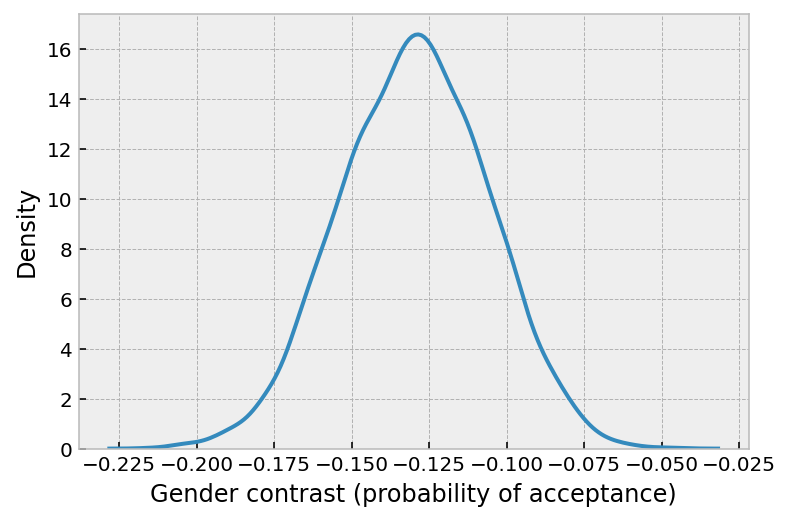

In [138]:
diff_prob = special.expit(idata_total2.posterior.sel(a_dim_0=0)) - special.expit(idata_total2.posterior.sel(a_dim_0=1))
sns.kdeplot(diff_prob.stack(dim=['chain', 'draw']).a.values)
plt.xlabel('Gender contrast (probability of acceptance)')

In [142]:
diff_prob.stack(dim=['chain', 'draw']).mean()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    a        float64 -0.1297

In [147]:
ucbadmit = pd.read_csv('Data/UCBadmit.csv', sep=';')
ucbadmit

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


In [157]:
gid, gender_idx = pd.factorize(ucbadmit['applicant.gender'])
did, dept_idx = pd.factorize(ucbadmit['dept'])

In [162]:
with pm.Model() as agm:
    a = pm.Normal('a', 0, 1.5, shape=2)
    p = pm.math.invlogit(a[gid])
    admit = pm.Binomial('admit', p=p, n=ucbadmit.applications.values, observed=ucbadmit.admit.values)
    idata_agm = pm.sample()
az.summary(idata_agm)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.219,0.040,-0.283,-0.156,0.001,0.000,3472.0,2864.0,1.0
a[1],-0.830,0.051,-0.913,-0.752,0.001,0.001,3569.0,2745.0,1.0


In [192]:
diff_p = special.expit(idata_agm.posterior['a'].sel(a_dim_0=0)) - special.expit(idata_agm.posterior['a'].sel(a_dim_0=1))
az.summary(diff_p)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.142,0.015,0.119,0.165,0.0,0.0,3652.0,2787.0,1.0


In [190]:
with pm.Model() as agm2:
    a = pm.Normal('a', 0, 1.5, shape=2)
    d = pm.Normal('d', 0, 1.5, shape=6)
    p = pm.math.invlogit(a[gid] + d[did])
    admit = pm.Binomial('admit', p=p, n=ucbadmit.applications.values, observed=ucbadmit.admit.values)
    idata_agm2 = pm.sample()
az.summary(idata_agm2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, d]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.523,0.544,-1.394,0.326,0.026,0.019,443.0,534.0,1.02
a[1],-0.426,0.544,-1.333,0.389,0.026,0.019,447.0,538.0,1.02
d[0],1.105,0.547,0.279,2.019,0.026,0.018,444.0,554.0,1.02
d[1],1.059,0.549,0.185,1.924,0.026,0.019,440.0,614.0,1.02
d[2],-0.157,0.547,-0.960,0.781,0.026,0.020,446.0,557.0,1.02
d[3],-0.188,0.547,-1.015,0.728,0.026,0.020,450.0,577.0,1.02
d[4],-0.634,0.551,-1.482,0.263,0.026,0.019,456.0,553.0,1.02
d[5],-2.192,0.560,-3.033,-1.285,0.025,0.018,492.0,686.0,1.02


In [193]:
diff_p = special.expit(idata_agm2.posterior['a'].sel(a_dim_0=0)) - special.expit(idata_agm2.posterior['a'].sel(a_dim_0=1))
az.summary(diff_p)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.022,0.018,-0.051,0.006,0.0,0.0,3771.0,3317.0,1.0


<AxesSubplot:xlabel='a', ylabel='Density'>

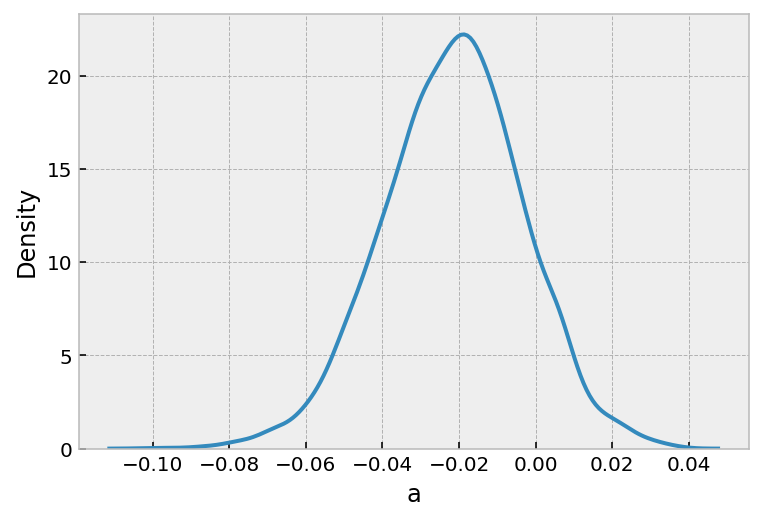

In [196]:
sns.kdeplot(diff_p.stack(dim=['chain', 'draw']))

In [198]:
ucbadmit

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


In [223]:
applicant_by_dept = ucbadmit.groupby(['dept', 'applicant.gender']).agg({'applications': sum})
applicant_by_dept_percentile = applicant_by_dept.groupby(level=0).apply(lambda x: x/float(x.sum()))
applicant_by_dept_percentile.reset_index().round(2)

,dept,applicant.gender,applications
0,A,female,0.12
1,A,male,0.88
2,B,female,0.04
3,B,male,0.96
4,C,female,0.65
5,C,male,0.35
6,D,female,0.47
7,D,male,0.53
8,E,female,0.67
9,E,male,0.33


In [276]:
# Number of applicants
N = 1000
# Even gender distribution
gender = np.random.choice([0, 1], size=N, replace=True)
# user's ability
ability = np.random.binomial(1, 0.1, size=N)
# Gender 1 tends to apply to Department 1, respectively
dept = np.random.binomial(1, p=np.where(gender==0, ability*0.5, 0.8))
# Simulate accept_rate[dept][gender]
accept_rate_u0 = np.array([[0.1, 0.1], [0.1, 0.3]])
accept_rate_u1 = np.array([[0.2, 0.3], [0.2, 0.5]])
# Generate probability
p = np.zeros(N)
mask = np.where(ability==0)
p[mask] = accept_rate_u0[gender[mask], dept[mask]]
mask = np.where(ability==1)
p[mask] = accept_rate_u1[gender[mask], dept[mask]]
accept = np.random.binomial(1, p)

In [277]:
## Total Effect Models
with pm.Model() as m_total:
    a = pm.Normal('a', 0, 1, shape=2)
    p = pm.math.invlogit(a[gender])
    _ = pm.Bernoulli('AcceptRate', p, observed=accept)
    idata_total = pm.sample()
az.summary(idata_total, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-1.91,0.14,-2.13,-1.70,0.0,0.0,3601.53,2914.16,1.0
a[1],-0.90,0.10,-1.06,-0.76,0.0,0.0,3396.90,2674.81,1.0


In [278]:
with pm.Model() as m_direct:
    a = pm.Normal('a', 0, 1, shape=(2,2))
    p = pm.math.invlogit(a[gender, dept])
    _ = pm.Bernoulli('AcceptRate', p, observed=accept)
    idata_direct = pm.sample()
az.summary(idata_direct, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"a[0, 0]",-1.99,0.14,-2.21,-1.76,0.00,0.0,6230.21,3025.82,1.0
"a[0, 1]",-0.71,0.41,-1.33,-0.03,0.01,0.0,6075.34,3304.90,1.0
"a[1, 0]",-1.84,0.29,-2.28,-1.37,0.00,0.0,6470.52,2773.05,1.0
"a[1, 1]",-0.73,0.10,-0.91,-0.58,0.00,0.0,6015.84,2843.72,1.0


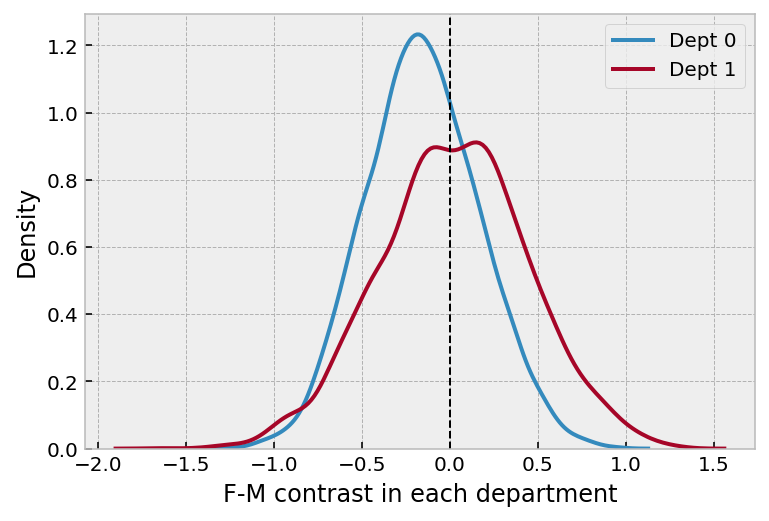

In [316]:
fm_dep0_contrast = idata_direct.posterior.sel(a_dim_0=0, a_dim_1=0) - idata_direct.posterior.sel(a_dim_0=1, a_dim_1=0)
fm_dep1_contrast = idata_direct.posterior.sel(a_dim_0=0, a_dim_1=1) - idata_direct.posterior.sel(a_dim_0=1, a_dim_1=1)
_, ax = plt.subplots()
sns.kdeplot(fm_dep0_contrast.stack(dim=['chain', 'draw']).a, label='Dept 0', ax=ax)
sns.kdeplot(fm_dep1_contrast.stack(dim=['chain', 'draw']).a, label='Dept 1', ax=ax)
ax.axvline(ymin=0, ymax=1.2, linestyle='--', color='k', lw=1)
ax.set_xlabel('F-M contrast in each department')
ax.legend()

In [317]:
with pm.Model() as m_direct:
    a = pm.Normal('a', 0, 1, shape=(2,2))
    buA = pm.Normal('buA', 0, 1)
    p = pm.math.invlogit(a[gender, dept] + buA*ability)
    _ = pm.Bernoulli('AcceptRate', p, observed=accept)
    idata_direct = pm.sample()
az.summary(idata_direct, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, buA]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"a[0, 0]",-2.03,0.15,-2.26,-1.78,0.00,0.00,5277.88,3210.50,1.0
"a[0, 1]",-1.16,0.46,-1.87,-0.41,0.01,0.01,3505.08,3327.60,1.0
"a[1, 0]",-1.88,0.29,-2.33,-1.41,0.00,0.00,4929.72,3189.75,1.0
"a[1, 1]",-0.78,0.11,-0.94,-0.61,0.00,0.00,4585.21,2855.32,1.0
buA,0.53,0.26,0.16,0.97,0.00,0.00,3499.87,3124.05,1.0


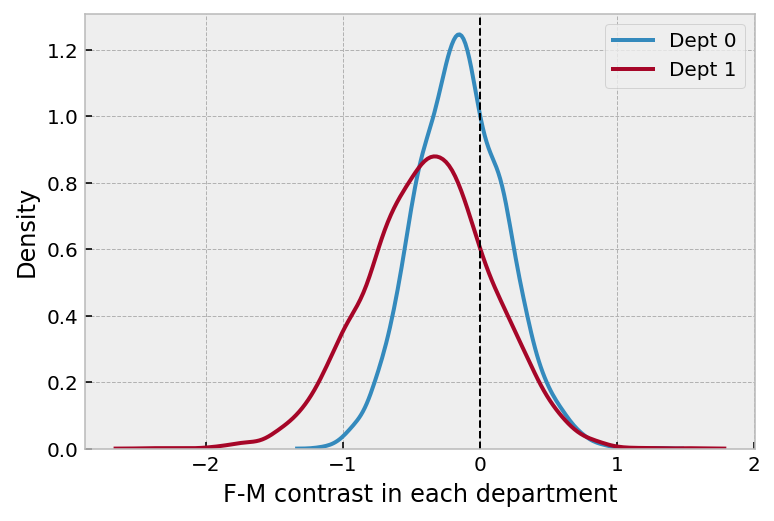

In [318]:
fm_dep0_contrast = idata_direct.posterior.sel(a_dim_0=0, a_dim_1=0) - idata_direct.posterior.sel(a_dim_0=1, a_dim_1=0)
fm_dep1_contrast = idata_direct.posterior.sel(a_dim_0=0, a_dim_1=1) - idata_direct.posterior.sel(a_dim_0=1, a_dim_1=1)
_, ax = plt.subplots()
sns.kdeplot(fm_dep0_contrast.stack(dim=['chain', 'draw']).a, label='Dept 0', ax=ax)
sns.kdeplot(fm_dep1_contrast.stack(dim=['chain', 'draw']).a, label='Dept 1', ax=ax)
ax.axvline(ymin=0, ymax=1.2, linestyle='--', color='k', lw=1)
ax.set_xlabel('F-M contrast in each department')
ax.legend()